# TP3: Stochastic Approximation Algorithms Applied to Optimal Execution

### By Zhiyuan XU and Wenjun LIU

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import Formatter
from matplotlib import cbook, dates

from datetime import datetime
import statsmodels.api as sm
from tqdm import tqdm
import os

In [5]:
%matplotlib inline

## 1. Optimal split of orders across liquidity pools

Given the objective function $
\Phi(r) = \Phi\left(r_{1}, \ldots, r_{N}\right):=\sum_{i=1}^{N} \varphi_{i}\left(r_{i}\right) := \sum_{i=1}^{N} \rho_{i} \mathbb{E}\left[  \min \left(r_{i} V, D_{i}\right)\right]
$, we aim at solving 
$
\max _{r \in \mathcal{P}_{N}} \Phi(r)
$ 

where
$$
\mathcal{P}_{N}:=\left\{r=\left(r_{i}\right)_{1 \leq i \leq N} \in \mathbb{R}_{+}^{N} \mid \sum_{i=1}^{N} r_{i}=1\right\}
$$

The Lagrangian approach gives 

$$
\begin{aligned}
r^{*} \in \arg \max _{\mathcal{P}_{N}} \Phi &\iff \forall i \in I_{N}, \quad \varphi_{i}^{\prime}\left(r_{i}^{*}\right)=\frac{1}{N} \sum_{j=1}^{N} \varphi_{j}^{\prime}\left(r_{j}^{*}\right) \\
&\iff \forall i \in I_{N}, \quad \mathbb{E}\left[V\left(\rho_{i} \mathbb{1}_{\left\{r_{i}^{*} V<D_{i}\right\}}-\frac{1}{N} \sum_{j=1}^{N} \rho_{j} \mathbb{1}_{\left\{r_{j}^{*} V<D_{j}\right\}}\right)\right]=0
\end{aligned}
$$

Consequently, the following zero search procedure can be used for $r^{*}$: 

$$
r_{i}^{n+1}=r_{i}^{n}+\gamma_{n+1} H_{i}\left(r^{n}, Y^{n+1}\right), r^{0} \in \mathcal{P}_{N}, i \in I_{N}
$$ 

where 
$$
H_{i}(r, Y)=V\left(\rho_{i} \mathbb{1}_{\left\{r_{i} V<D_{i}\right\}}-\frac{1}{N} \sum_{j=1}^{N} \rho_{j} \mathbb{1}_{\left\{r_{j} V<D_{j}\right\}}\right)
$$

The performance is defined by $$\frac{\text { CR }^{\text{opti}}}{\text { CR }^{\text{oracle}} } \in [0, 1] $$ 

We also generate the pseudo-real data available volume by: 

$$
\forall 1 \leq i \leq N, \quad D_{i}:=\beta_{i}\left(\left(1-\alpha_{i}\right) V+\alpha_{i} S_{i} \frac{\mathbb{E} V}{\mathbb{E} S_{i}}\right)
$$

In [6]:
# Our peudo data setting:
# use LVMH.h5 as V and the others as dark pool size

N = 3
beta_scale = np.array([0.6, 0.1, 0.05])
alpha_comb = np.array([0.2, 0.5, 0.8])
# the dark pool trading parameters
rho_rebate = np.array([0.01, 0.02, 0.05])

stock_data = ['LVMH.h5', 'TOTAL.h5', 'BOUYGUES.h5', 'SANOFI.h5']

# choose 12 trading days as the periode
begin_date = pd.to_datetime("2011-04-03")
end_date = pd.to_datetime("2011-04-18")

In [4]:
def get_asset_V(name):
    df_trades = pd.read_hdf(f"Data/{stock_data[0]}")
    df_trades.loc[:, "Volume"] = df_trades.loc[:, "TradedQty"] 
    df_trades.loc[:, "Date"] = df_trades.index.date
    df_trades = df_trades.reset_index().set_index(["Date", "Time"]).loc[begin_date:end_date]
    return df_trades

def get_pools(names):
    trades = []
    for name in names:
        df_trades_tmp = pd.read_hdf(f"Data/{name}")
        df_trades_tmp.loc[:, "Volume"] = df_trades_tmp.loc[:, "TradedQty"]
        df_trades_tmp.loc[:, "Date"] = df_trades_tmp.index.date
        df_trades_tmp = df_trades_tmp.reset_index().set_index(["Date", "Time"]).loc[begin_date:end_date]
        trades.append(df_trades_tmp)
    return trades

def compute_oracle_cost(tot, dark_pools_arg, rho_rebate, N):
    j = N - 1
    cr_oracle = 0
    while j >= 0 and tot > 0:
        cr_oracle += rho_rebate[j] * (min(tot, dark_pools_arg[j][i]))
        tot -= min(tot, dark_pools[j][i])
        j -= 1
    return cr_oracle

In [5]:
# choose a horizon T (seconds)
T = "5S"
eps = 1e-8

# read all data
df_trades_V = get_asset_V(stock_data[0])
trades = get_pools(stock_data[1:])

In [6]:
window = 50
log_cr = pd.DataFrame(columns=["Oracle", "Optimization"])
x_vlines = [0]
   
for date, trades_date in df_trades_V.groupby(level=0):
    V = trades_date.droplevel(0).resample(T).sum().Volume
    t_index = V.index
    t_index_real = []
    V = V.to_numpy(copy=True)
    dark_pools = []
    
    # reset r for each day
    r = np.array([1/N]*N)
    
    # compute Di of each dark pool (pseudo-data generation)
    for i in range(N):
        Si = trades[i].loc[date].resample(T).sum().Volume.to_numpy(copy=True)
        Si.resize(V.shape)
        dark_pools.append(Si)
    dark_pools = np.array(dark_pools)
    
    ESi = np.mean(dark_pools, axis=0, keepdims=True) + eps
    dark_pools = beta_scale.reshape(-1, 1)*((1-alpha_comb.reshape(-1, 1))*V + alpha_comb.reshape(-1, 1)*dark_pools*V.mean()/ESi)

    cr_opti_day = []
    cr_oracle_day = []
    
    for i in range(V.shape[0]): 
        if V[i] == 0:
            continue
        cr_opti, mean_rho = 0, 0

        for j in range(N):
            cr_opti += rho_rebate[j]*min(r[j]*V[i], dark_pools[j, i])
            if r[j]*V[i] < dark_pools[j][i]:
                mean_rho += rho_rebate[j] / N
        
        dark_pool = dark_pools[:, i]
        r += ((r*V[i] < dark_pool)*rho_rebate - mean_rho)*0.5
        r[r > 1] = 1
        r[r < 0] = 0
        r /= r.sum()
        
        cr_opti_day.append(cr_opti)
        cr_oracle_day.append(compute_oracle_cost(V[i], dark_pools, rho_rebate, N))
        t_index_real.append(t_index[i])

    x_vlines.append(x_vlines[-1] + len(cr_opti_day))
    log_cr_day = pd.DataFrame(
        list(zip(cr_oracle_day, cr_opti_day)), columns=["Oracle", "Optimization"], index=t_index_real)
    log_cr_day.loc[:, "CR_ratio"] = log_cr_day.loc[:, "Optimization"] / (log_cr_day.loc[:, "Oracle"] + eps)
    log_cr = log_cr.append(log_cr_day.rolling(window).mean())

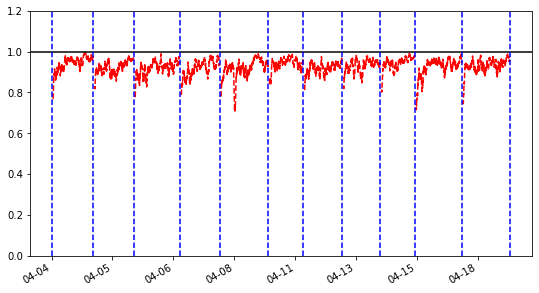

In [15]:
log_cr_roll = log_cr

class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        """Return the label for time x at position pos."""
        ind = int(round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        return self.dates[ind].strftime(self.fmt)
    
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.xaxis.set_major_formatter(MyFormatter(log_cr_roll.index))
ax.plot(range(log_cr_roll.shape[0]), log_cr_roll.loc[:, "CR_ratio"], '--', color='r')
ax.axhline(1, 0, log_cr_roll.shape[0], color='k')
for x in x_vlines:
    ax.axvline(x, color='b', linestyle='--')
ax.set_ylim(0, 1.2)
fig.autofmt_xdate()
plt.show()

The performance is shown in the figure above with the red curve. The shape is different from that of the reference, after a careful examination, we state that it's due to the fact that an uniforme initialization could eventually consumes all liquidity at market openning in the case $\sum \beta < 1$, the traded volume are similar in all the three assets, thus no update of weight is done at the begining.

Then, no trades happen at some time slots during the day (cf tp1 intraday volume curve), all cost reductions are 0 if there is no trades happenned, thus lowers the performance. In this way, we have a daily "V" shape. Thus, we avoided recording such results and obtained a daily increasing performance. 

Overall, the weight update scheme helps to improve the performance (performance curve moves upward) but the shape of the curve remains the same for different settings of $\gamma_n$

## 2. Optimal posting price of limit orders: learning by trading

In [8]:
import statsmodels.api as sm


def Find_tau_bid(BestBid,Traded,tick,delta):
    tau = []
    p = 0
    while p+1 < len(Traded):
        tra = Traded[p+1:]
        condi = (tra <= BestBid[p] - tick*delta)
        if condi.any():
            new_tau = condi.argmax()
            tau.append(new_tau+1)
            p += new_tau+1
        else:
            return tau
    return tau


def Find_tau_ask(BestAsk,Traded,tick,delta):
    tau = []
    p = 0
    while p+1 < len(Traded):
        tra = Traded[p+1:]
        condi = (tra >= BestAsk[p] + tick*delta)
        if condi.any():
            new_tau = condi.argmax()
            tau.append(new_tau+1)
            p += new_tau+1
        else:
            return tau
    return tau

In [9]:
def estimate_lambda(tau,T):
    new_tau = ((pd.Series(tau)).apply(lambda x:x if x < T else T))
    return (new_tau < T).sum()/new_tau.sum()

In [10]:
def find_list(Best,Traded,tick,T,mode = 'bid'):
    lamb_list = []
    for delta in range(5):
        if mode == 'bid':
            tau = Find_tau_bid(Best,Traded,tick,delta)
        if mode == 'ask':
            tau = Find_tau_ask(Best,Traded,tick,delta)
        lamb = estimate_lambda(tau,T)
        lamb_list.append(lamb)
    return lamb_list

def reg(lamb_list):
    y = np.log(lamb_list)
    x = list(range(5))
    x = sm.add_constant(x)
    rlm_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
    model = rlm_model.fit()
    A = np.exp(model.params[0])
    a = -model.params[1]
    return A,a

In [11]:
# "LVMH" "SANOFI" "TOTAL" "BOUYGUES"
Chemin = "Data"
StockName = "LVMH"
stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
stock = stock[stock.index.month == 2]
delta_max = 4
T = 15
tick = 0.05
BestBid = stock['BidPrice'].to_numpy()
BestAsk = stock['AskPrice'].to_numpy()
Traded = stock['TradedPrice'].to_numpy()

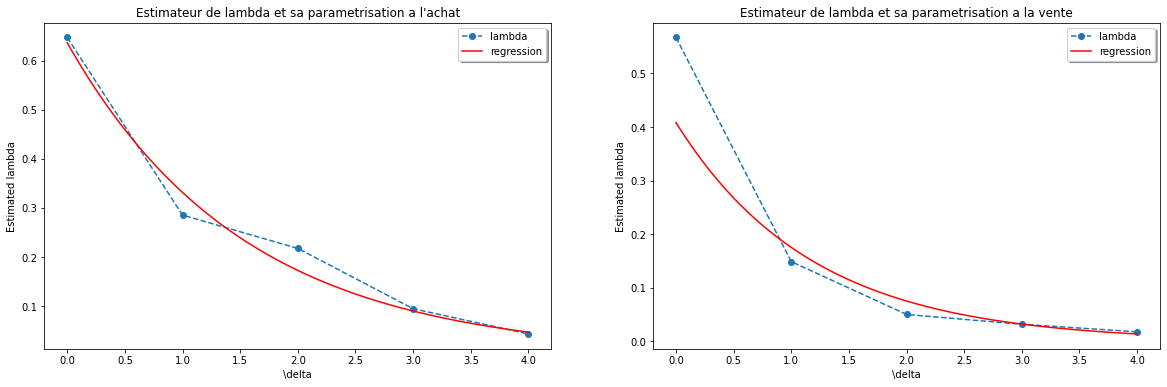

In [12]:
lamb_bid = find_list(stock['BidPrice'].to_numpy(),Traded,tick,T,mode = 'bid')    
lamb_ask = find_list(stock['AskPrice'].to_numpy(),Traded,tick,T,mode = 'ask')
A_bid,a_bid = reg(lamb_bid)
A_ask,a_ask = reg(lamb_ask)

xx = np.linspace(0,4,100)

f, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(lamb_bid,'--o',label = 'lambda')
axs[0].plot(xx,A_bid * np.exp(-a_bid*xx),'r',label = 'regression')
axs[0].set_title("Estimateur de lambda et sa parametrisation a l'achat")
axs[0].set_xlabel('\delta')
axs[0].set_ylabel('Estimated lambda')
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(lamb_ask,'--o',label = 'lambda')
axs[1].plot(xx,A_ask * np.exp(-a_ask*xx),'r',label = 'regression')
axs[1].set_title('Estimateur de lambda et sa parametrisation a la vente')
axs[1].set_xlabel('\delta')
axs[1].set_ylabel('Estimated lambda')
axs[1].legend(shadow=True, fancybox=True)

Nous voyons ici que $\lambda$ décroit bien avec $\delta$ et suit bien une forme exponentielle
$$\lambda (x) = Ae^{(-ax)}$$
les côtés vente et achat ont tous les deux cette propriétés. Ceci confirme l'hypothèse du modèle.